In [100]:
import os

import numpy as np
import uproot
import matplotlib.pyplot as plt
import modplot
import pandas as pd
from glob import glob
from collections import Counter

In [2]:
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = False

In [3]:
def find_string_vals_in_file(file_name, string_to_search):
    """ Return values from all lines in the file that contains given string """
    vals = []
    # Open the file in read only mode
    with open(file_name, 'r') as read_obj:
        # Read all lines in the file one by one
        for line in read_obj:
            # For each line, check if line contains the string
            if string_to_search in line:
                vals.append(line)
                #vals.append(line.split(': ')[-1].split('\n')[0])
                #return True
    if len(vals) == 1:
        return vals[0]
    return vals

## Loading the Data

In [64]:
# pass in the full directory
data_path = '/gpfs3/harvard/abadea/data/NSW/oct_sim/simResults_060320_093832' 
list_of_dirs = glob(data_path+'/*')
# construct a list of dictionaries for each data file
data = []
nFiles = 0
for direct in list_of_dirs:
    if nFiles % 10 == 0: print("File {}/{}".format(nFiles,len(list_of_dirs)))
    try:
        file = glob(direct+'/stdout*.txt')[0]
        data_file = glob(direct+'/*.root')[0]
        # load the parameters
        nEvent = float(find_string_vals_in_file(file,'muons triggered out of ').split('out of ')[-1].split(' muons that should trigger\n')[0])
        bkgRate = float(find_string_vals_in_file(file,' >> Background rate of ').split('>> Background rate of ')[-1].split(' Hz per strip')[0])
        mmEffs = [float(i.split(':')[-1].split('\n')[0]) for i in find_string_vals_in_file(file,"MM efficiency")]
        # load the data
        data_file = uproot.open(data_file)
        real_x_muon = data_file['gingko']['real_x_muon'].array()
        real_y_muon = data_file['gingko']['real_y_muon'].array()
        trig_x = data_file['gingko']['trig_x'].array()
        trig_y = data_file['gingko']['trig_y'].array()
        # append dictionary of parameters and data
        data.append({'nEvent':nEvent,
                     'bkgRate':bkgRate,
                     'mmEffs':mmEffs,
                     'real_x_muon':real_x_muon,
                     'real_y_muon':real_y_muon,
                     'trig_x':trig_x,
                     'trig_y':trig_y,})
        nFiles += 1
    except:
        print("Failed directory: {}".format(direct))
        continue

File 0/60
File 10/60
File 20/60
File 30/60
File 40/60
File 50/60


In [65]:
print("Number of loaded files: {}".format(nFiles))

Number of loaded files: 60


## Plot a sample distribution

In [67]:
'''
# compute the distributions to determine the bin-by-bin corrections
bins = np.linspace(0, 3500, 350)
density = False
#plt.hist(nature['data_thrusts'], bins=bins, histtype='step', color='black', density=density)
real_x_muon_hist = plt.hist(data[0]['real_x_muon'], bins=bins, histtype='step', color='black', density=density, label='Real Muon X')[0]
real_y_muon_hist = plt.hist(data[0]['real_y_muon'], bins=bins, histtype='step', color='blue', density=density, label='Real Muon Y')[0]
#trig_x_hist = plt.hist(trig_x, bins=bins, histtype='step', color='red', density=density)[0]
#trig_y_hist = plt.hist(trig_y, bins=bins, histtype='step', color='green', density=density)[0]

#plt.yscale('log')
plt.legend(loc="upper right")
plt.show()
'''

'\n# compute the distributions to determine the bin-by-bin corrections\nbins = np.linspace(0, 3500, 350)\ndensity = False\n#plt.hist(nature[\'data_thrusts\'], bins=bins, histtype=\'step\', color=\'black\', density=density)\nreal_x_muon_hist = plt.hist(data[0][\'real_x_muon\'], bins=bins, histtype=\'step\', color=\'black\', density=density, label=\'Real Muon X\')[0]\nreal_y_muon_hist = plt.hist(data[0][\'real_y_muon\'], bins=bins, histtype=\'step\', color=\'blue\', density=density, label=\'Real Muon Y\')[0]\n#trig_x_hist = plt.hist(trig_x, bins=bins, histtype=\'step\', color=\'red\', density=density)[0]\n#trig_y_hist = plt.hist(trig_y, bins=bins, histtype=\'step\', color=\'green\', density=density)[0]\n\n#plt.yscale(\'log\')\nplt.legend(loc="upper right")\nplt.show()\n'

## Compute the distributions of interest

In [68]:
# Calculate the number of triggered muons 
# This computation takes a while
xCut = 5
yCut = 5
counter = 0
print('----------------------------------------')
print('Computing the number of triggered muons')
for job in data:
    if counter % 10 == 0: print("Job {}/{}".format(counter,len(data)))
    real_x_muon = job['real_x_muon']
    real_y_muon = job['real_y_muon']
    trig_x = job['trig_x']
    trig_y = job['trig_y']
    TObs = 0
    for i in range(len(real_x_muon)):
        realMuonX = real_x_muon[i]
        realMuonY = real_y_muon[i]
        for j in range(len(trig_x[i])):
            trigX = trig_x[i][j]
            trigY = trig_y[i][j]
            if (abs(realMuonX - trigX) < xCut) and (abs(realMuonY - trigY) < yCut):
                TObs+=1
                break  
    job['TObs'] = TObs
    counter += 1
print('Finished!')
print('----------------------------------------')

----------------------------------------
Computing the number of triggered muons
Job 0/60
Job 10/60
Job 20/60
Job 30/60
Job 40/60
Job 50/60
Finished!
----------------------------------------


In [69]:
# Compute the group, detector, and trigger efficiencies
# P = product of (1-(1-Ed_{i1})*(1-Ed_{i2})) where i1,i2 are members of each of the four groups 
# group 1 includes the first two x-layers, group 2 includes the u-layers, 
# group 3 includes the v-layers and group 4 includes the final two x-layers.
print('----------------------------------------')
print("Computing the trigger efficiencies")
counter = 0
for job in data:
    if counter % 10 == 0: print("Job {}/{}".format(counter,len(data)))
    mmEffs = job['mmEffs']
    # This probability should not be trusted need to think more about that
    probTrig = [(1-(1-mmEffs[i])*(1-mmEffs[i+1])) for i in range(0,len(mmEffs),2)]
    probTrig = np.array(probTrig).prod()
    
    try:
        # Trigger Efficiency = NTrigs / NEvents
        # Useful to determine how the entire trigger system behaves. 
        trigEff = job['TObs']/(job['nEvent'])
        trigEff_err = (1/job['nEvent'])*(job['TObs'] * (1-job['TObs']/job['nEvent']))**0.5
        # Trigger Efficiency = NTrigs / NExpectedTrigs
        # Useful to compare how factors external to the trigger effect the efficiency. i.e. we expect X triggers 
        # just based on the efficiencies but see Y then maybe other factors such as poor timing resolution could be 
        # in play
        NExp = probTrig*job['nEvent']
        trigEff_GivenMMEffs = job['TObs']/(NExp)
        trigEff_GivenMMEffs_err = (1/NExp)*(job['TObs'] * (1-job['TObs']/NExp))**0.5
    except:
        print("Problem with producing the efficiencies. Setting all to -999.0")
        trigEff = -999.0
        trigEff_err = -999.0
        trigEff_GivenMMEffs = -999.0
        trigEff_GivenMMEffs_err = -999.0
        
    job.update({'probTrig':probTrig,
               'NExp':NExp,
               'trigEff':trigEff,
               'trigEff_err':trigEff_err,
               'trigEff_GivenMMEffs': trigEff_GivenMMEffs,
               'trigEff_GivenMMEffs_err': trigEff_GivenMMEffs_err})
    counter += 1
print("Finished!")
print('----------------------------------------')

----------------------------------------
Computing the trigger efficiencies
Job 0/60
Job 10/60
Job 20/60
Job 30/60
Job 40/60
Job 50/60
Finished!
----------------------------------------


In [70]:
# Dictionary to store the data
hist_data = {'BkgRates':[job['bkgRate'] for job in data],
             'TrigEffs':[job['trigEff'] for job in data],
             'TrigEff_errs':[job['trigEff_err'] for job in data],
             'ProbTrigs':[job['probTrig'] for job in data],
    }

In [71]:
hist_data_db = pd.DataFrame.from_dict(hist_data)
hist_data_db.head()

,BkgRates,ProbTrigs,TrigEff_errs,TrigEffs
0,1.0,1.000000,0.027129,0.920000
1,1.0,0.960596,0.043071,0.757576
2,1.0,0.902378,0.047476,0.727273
3,1.0,0.902378,0.047776,0.711111
4,1.0,0.902378,0.050910,0.686747


In [72]:
# a dictionary to hold plotting information about the observables
obs = {}
obs.setdefault('TrigEff_BkgRate_ProbTrig',{}).update({
    'xlim': (10**0,10**6), 'ylim': (0,1.0), 'ylim_ratio': (0.7,1.3), 'ytick_ratio_step':0.15,
    'xlabel': 'Background Rate (Hz)', 'ylabel': 'Trigger Efficiency', 'ylabel_ratio':"TEST",
    'legend_loc': 'lower left', 'legend_ncol': 1,
    'x':'BkgRates','y':'TrigEffs','y_err':'TrigEff_errs',
    'scan':'ProbTrigs'
})

histStyle = {'ls': '-', 'marker': 'o', 'ms': 3.5, 'zorder': 1}
legend_opts = {'handlelength': 2.0, 'loc': 'lower left', 'frameon': False, 'numpoints': 1}

## Plot Background Rate vs Trigger Efficiency for Each Trigger Probability

In [73]:
ob = obs['TrigEff_BkgRate_ProbTrig']

In [91]:
# Sort the data based on probability of trigger
prob_dict = {}
prob_sig_digs = 20
for i in range(len(hist_data['ProbTrigs'])):
    if round(hist_data['ProbTrigs'][i],prob_sig_digs) not in prob_dict.keys():
        prob_dict[round(hist_data['ProbTrigs'][i],prob_sig_digs) ] = {'BkgRates':[],
                                                'TrigEffs':[],
                                                'TrigEff_errs':[]}
    prob_dict[round(hist_data['ProbTrigs'][i],prob_sig_digs) ]['BkgRates'].append(hist_data['BkgRates'][i])
    prob_dict[round(hist_data['ProbTrigs'][i],prob_sig_digs) ]['TrigEffs'].append(hist_data['TrigEffs'][i])
    prob_dict[round(hist_data['ProbTrigs'][i],prob_sig_digs) ]['TrigEff_errs'].append(hist_data['TrigEff_errs'][i])

for key in prob_dict.keys():
    sorted_data = sorted(zip(prob_dict[key]['BkgRates'], prob_dict[key]['TrigEffs'], prob_dict[key]['TrigEff_errs']))
    prob_dict[key]['BkgRates'] = [i[0] for i in sorted_data]
    prob_dict[key]['TrigEffs'] = [i[1] for i in sorted_data]
    prob_dict[key]['TrigEff_errs'] = [i[2] for i in sorted_data]

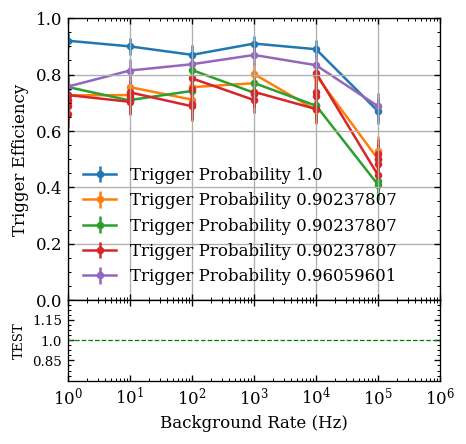

In [93]:
fig, [ax0, ax1] = modplot.axes(**ob)
# additional axis settings
# ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.grid()
ax1.set_xscale('log')

for key in prob_dict.keys():

    # plot the distribution
    ax0.errorbar(prob_dict[key]['BkgRates'],prob_dict[key]['TrigEffs'],yerr=prob_dict[key]['TrigEff_errs'], label='Trigger Probability {}'.format(key), **histStyle)

ax1.plot(ob['xlim'], [1, 1], '--', color='green', lw=0.75)
# legend style and ordering
loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 1)
order = range(len(prob_dict.keys()))

# plot the legend
ax0.legend(**legend_opts)

fig.savefig('TrigEff_BkgRate_ProbTrig.pdf', bbox_inches='tight')
plt.show()

## Plot Background Rate vs Trigger Efficiency for Each Killed MM Plane

In [151]:
plt.rcParams['figure.figsize'] = (50,15)
plt.rcParams['figure.dpi'] = 240
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

In [170]:
obs.setdefault('TrigEff_BkgRate_MMKillIndex',{}).update({
    'xlim': (10**0,10**5), 'ylim': (0.5,1.0), 'ylim_ratio': (0.7,1.3), 'ytick_ratio_step':0.15,
    'xlabel': 'Background Rate (Hz)', 'ylabel': 'Trigger Efficiency', 'ylabel_ratio':"TEST",
    'legend_loc': 'lower left', 'legend_ncol': 2,
    'x':'BkgRates','y':'TrigEffs','y_err':'TrigEff_errs',
    'stamp_xy': (0.5, 0.9)
})


ob = obs['TrigEff_BkgRate_MMKillIndex']

In [153]:
# Sort the data based on index of killed mm
killed_mm = {}
kill_eff = 0.3
for job in data:
    mm_indx = -1
    try:
        mm_indx = job['mmEffs'].index(kill_eff)
    except:
        if job['mmEffs'][0] != 1: continue
        print(job['mmEffs'])
    if mm_indx not in killed_mm.keys():
        killed_mm[mm_indx] = {'BkgRates':[],
                              'TrigEffs':[],
                              'TrigEff_errs':[]}
    killed_mm[mm_indx]['BkgRates'].append(np.array(job['bkgRate']))
    killed_mm[mm_indx]['TrigEffs'].append(np.array(job['trigEff']))
    killed_mm[mm_indx]['TrigEff_errs'].append(np.array(job['trigEff_err']))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [154]:
killed_mm_db = pd.DataFrame.from_dict(killed_mm)
killed_mm_db.head()

,-1,0,1,2,3,4,5,6,7
BkgRates,"[1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]","[1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]","[1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]","[1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]","[1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]","[1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]","[1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]","[1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]","[1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]"
TrigEff_errs,"[0.027129319932501065, 0.029999999999999995, 0...","[0.047475724351553956, 0.04788613445291623, 0....","[0.047776342212139555, 0.04517868817257643, 0....","[0.05091045321816185, 0.04704108056426865, 0.0...","[0.04968146383954969, 0.047640354157589215, 0....","[0.04632534355859112, 0.04820276365195999, 0.0...","[0.047475724351553956, 0.047068399075540654, 0...","[0.04865303157988616, 0.04434057411245872, 0.0...","[0.048304589153964794, 0.047475724351553956, 0..."
TrigEffs,"[0.92, 0.9, 0.87, 0.91, 0.89, 0.67]","[0.7272727272727273, 0.7032967032967034, 0.786...","[0.7111111111111111, 0.7368421052631579, 0.694...","[0.6867469879518072, 0.7303370786516854, 0.687...","[0.6593406593406593, 0.7191011235955056, 0.75,...","[0.7558139534883721, 0.7078651685393258, 0.816...","[0.7272727272727273, 0.7096774193548387, 0.741...","[0.7261904761904762, 0.7553191489361702, 0.755...","[0.7, 0.7272727272727273, 0.7111111111111111, ..."


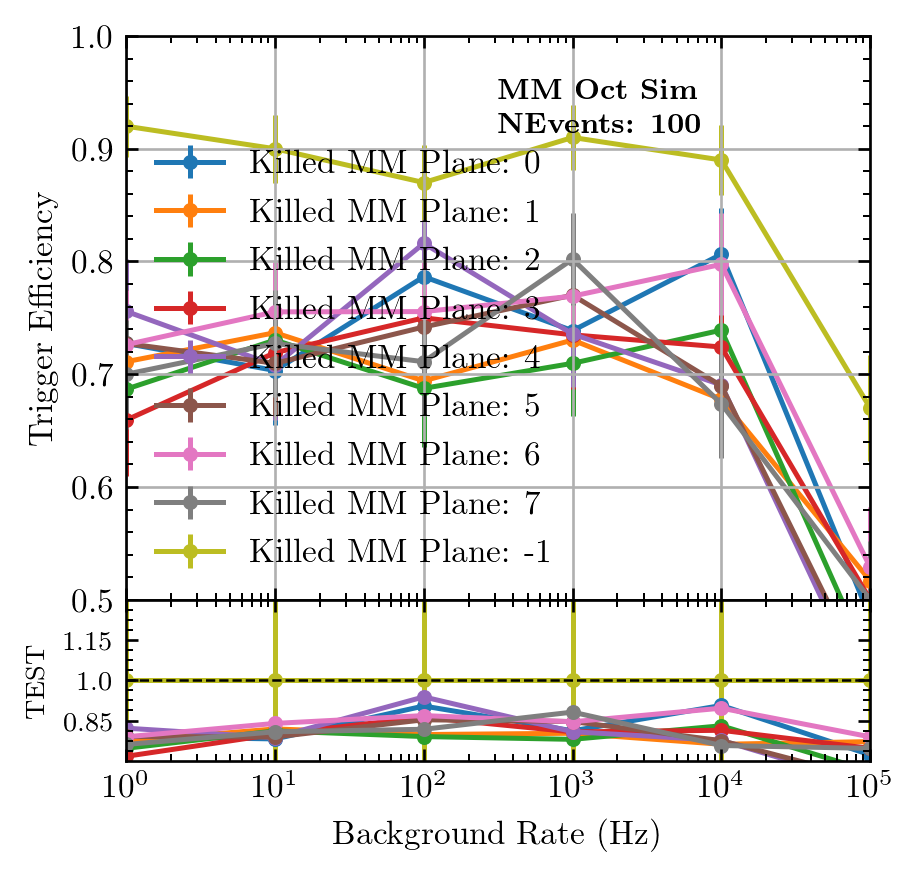

In [171]:
fig, [ax0, ax1] = modplot.axes(**ob)
# additional axis settings
# ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.grid()
ax1.set_xscale('log')

for key in killed_mm.keys():
    
    ratio = np.array(killed_mm[key]['TrigEffs'])/np.array(killed_mm[-1]['TrigEffs'])
    ratio_errs = np.array(killed_mm[key]['TrigEff_errs'])/np.array(killed_mm[-1]['TrigEff_errs'])
    
    # plot the distribution
    ax0.errorbar(killed_mm[key]['BkgRates'],killed_mm[key]['TrigEffs'],yerr=killed_mm[key]['TrigEff_errs'], label='Killed MM Plane: {}'.format(key), **histStyle)
    ax1.errorbar(killed_mm[key]['BkgRates'],
                 ratio,
                 yerr=ratio_errs, 
                 label='Killed MM Plane: {}'.format(key), 
                 **histStyle)
ax1.plot(ob['xlim'], [1, 1], '--', color='black', lw=0.75)
# legend style and ordering
loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 1)
order = range(len(killed_mm.keys()))

# plot the legend
ax0.legend(**legend_opts)

# stamp to put on the plots
modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
              line_0=r'\textbf{MM Oct Sim}',
              line_1=r'\textbf{NEvents: %i}'%(data[0]['nEvent'])
             )
    
fig.savefig('TrigEff_BkgRate_MMKillIndex.pdf', bbox_inches='tight')
plt.show()

## Convert to python file

In [15]:
# Convert notebook into python file
!jupyter nbconvert --to python 'EfficiencyPlots.ipynb'

## Commit to github

In [ ]:
!git add "EfficiencyPlots.ipynb"
!